In [43]:
# CELL 1 - Kütüphaneler ve Veri Yükleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Stil ayarı (sunumda güzel dursun)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



# Veri yükleme
df = pd.read_csv('data/raw/final_proje_dataset_CLEAN.csv')

print(f"Dataset loaded")
print(f"#Rows: {df.shape[0]:,}")
print(f"#Columns: {df.shape[1]}")
df.head()

Dataset loaded
#Rows: 11,060
#Columns: 180


,date,/m/05p0rrx,/m/0108bn2x,/g/11tskkw5c9,/g/11sfdkgmfn,/g/11hcz1r4wl,/g/11pcs9ny8w,/g/11bw1zmnts,/m/0273t5w,/g/1234z6p9,...,/g/11jt20l831,/g/11h7_q3l6z,/g/11jp_j0m6d,/m/01h7lh,/m/0rfgxy2,/g/11ww08lq0j,/g/11vhqc7hb1,/m/02xz2,/m/0179v6,Country
0,2021-12-26,37,14,0,0,2,1,0,53,0,...,0,2,0,30,32,0.0,0.0,17.0,0.0,US
1,2022-01-02,47,18,0,0,2,2,0,70,0,...,0,4,0,27,19,0.0,0.0,16.0,0.0,US
2,2022-01-09,43,18,0,0,2,1,0,71,0,...,0,4,0,27,18,0.0,0.0,15.0,0.0,US
3,2022-01-16,49,18,0,0,2,1,0,70,0,...,0,4,0,30,13,0.0,0.0,13.0,0.0,US
4,2022-01-23,63,19,0,0,2,1,0,74,0,...,0,4,0,39,15,0.0,0.0,14.0,0.0,US


In [44]:
feature_columns = [col for col in df.columns if col not in ['date', 'Country']]
n_features = len(feature_columns)

print(f"1. Total #Features: {n_features}")


n_countries = df['Country'].nunique()
print(f"2. #Countries: {n_countries}")
print(f"   Countries: {sorted(df['Country'].unique())}")




df['date'] = pd.to_datetime(df['date'])
min_date = df['date'].min()
max_date = df['date'].max()
n_weeks = df['date'].nunique()

print(f"3. Time interval:")
print(f"   First: {min_date.date()}")
print(f"   Last: {max_date.date()}")
print(f"   Total #weeks: {n_weeks}")
print(f"   Expected 3 years ({(max_date - min_date).days // 7 + 1} week)")




#check first and last week for each country
country_date_range = df.groupby('Country')['date'].agg(['min', 'max']).reset_index()
country_date_range['min'] = pd.to_datetime(country_date_range['min'])
country_date_range['max'] = pd.to_datetime(country_date_range['max'])
country_date_range['missing_week'] = (country_date_range['min'] == min_date) & (country_date_range['max'] == max_date)

print(f"\n   No missing data for any country?: {'YES' if country_date_range['missing_week'].all() else 'NO'}")
if not country_date_range['missing_week'].all():
    print("   Countries with missing data:")
    print(country_date_range[~country_date_range['missing_week']][['Country', 'min', 'max']])

1. Total #Features: 178
2. #Countries: 70
   Countries: ['AE', 'AR', 'AT', 'AU', 'BD', 'BE', 'BG', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CZ', 'DE', 'DK', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GH', 'GR', 'HK', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IT', 'JP', 'KE', 'KR', 'LK', 'LT', 'LV', 'MA', 'MM', 'MX', 'MY', 'NG', 'NL', 'NO', 'NZ', 'PE', 'PH', 'PK', 'PL', 'PT', 'RO', 'RS', 'RU', 'SA', 'SE', 'SG', 'SI', 'SK', 'TH', 'TN', 'TR', 'TW', 'UA', 'US', 'UY', 'VE', 'VN', 'ZA']
3. Time interval:
   First: 2021-12-26
   Last: 2024-12-29
   Total #weeks: 158
   Expected 3 years (158 week)

   No missing data for any country?: YES


In [45]:
import pandas as pd
import json
import re

# 1. JSON file ve Mapping (keywords) dicitonary
def norm_label(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[’']", "", s)
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", "_", s)
    return s

with open('data/raw/keywords_FINAL_2025.json', 'r', encoding='utf-8') as f:
    keyword_data = json.load(f)

# Topic ID -> original keyword
topic_to_label = {}
for cat in keyword_data['categories']:
    for sg in cat['sub_groups']:
        for q in sg['queries']:
            topic_to_label[q['topic_id']] = norm_label(q['label'])


feature_columns = [col for col in df.columns if col not in ['date', 'Country']]

print("4. For each feature, how many different countries showed interest (the count of unique countries where the score was greater than 10)\n")





feature_coverage = []

for col in feature_columns:
    # Calculate the number of unique countries where the score is greater than 10
    active_countries = df[df[col] > 5]['Country'].nunique()
    
    # Convert the Topic ID to a readable label, if not available, keep the ID
    label = topic_to_label.get(col, col)
    
    feature_coverage.append({
        'feature': label,
        'active_country_count': active_countries
    })

coverage_df = pd.DataFrame(feature_coverage)
coverage_df = coverage_df.sort_values('active_country_count', ascending=False).reset_index(drop=True)

#Results
print(f"Features with global interest (50+ countries over 10 score): {len(coverage_df[coverage_df['active_country_count'] >= 50])}")
print(f"Medium interest (20-49 countries): {len(coverage_df[(coverage_df['active_country_count'] >= 20) & (coverage_df['active_country_count'] < 50)])}")
print(f"Little or no interest (less than 20 countries): {len(coverage_df[coverage_df['active_country_count'] < 20])}")
print(f"No interest from any country: {len(coverage_df[coverage_df['active_country_count'] == 0])}")

print("\nTop 10 features with the most interest:")
print(coverage_df.head(10)[['feature', 'active_country_count']].to_string(index=False))

print("\nTop 10 features with the least interest:")
print(coverage_df.tail(10)[['feature', 'active_country_count']].to_string(index=False))

4. For each feature, how many different countries showed interest (the count of unique countries where the score was greater than 10)



Features with global interest (50+ countries over 10 score): 76
Medium interest (20-49 countries): 45
Little or no interest (less than 20 countries): 57
No interest from any country: 9

Top 10 features with the most interest:
       feature  active_country_count
       bitcoin                    70
      ethereum                    70
     inflation                    70
   lamborghini                    70
       ferrari                    70
   gun_control                    70
   liposuction                    70
patek_philippe                    70
         rolex                    70
 louis_vuitton                    70

Top 10 features with the least interest:
          feature  active_country_count
     alex_pereira                     1
    crypto_wallet                     0
 plant_based_diet                     0
             tofu                     0
 carbon_emissions                     0
     electric_car                     0
   pirated_movies                     0
strea

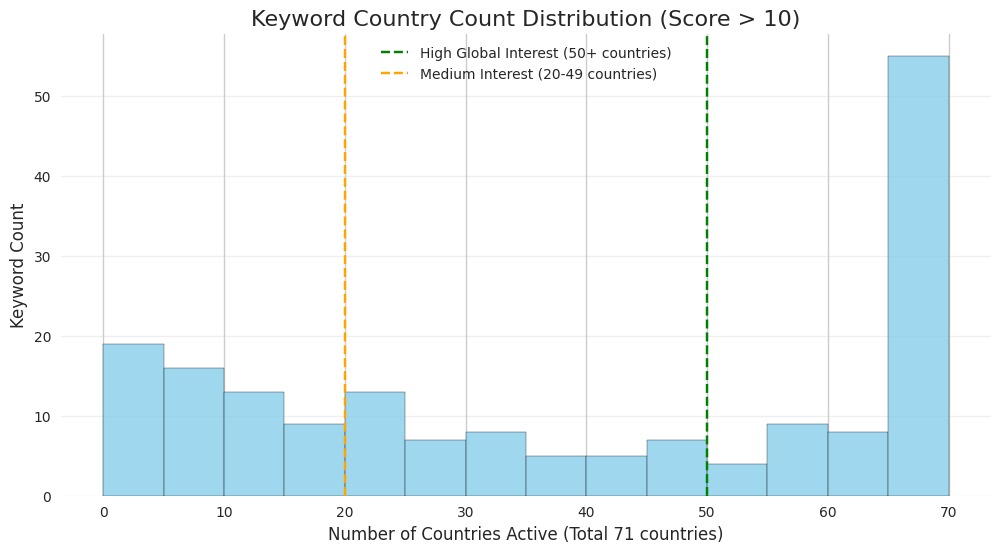

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Histogram: show distribution of active country counts in coverage_df
plt.hist(coverage_df['active_country_count'], bins=range(0, 72, 5), 
    color='skyblue', edgecolor='black', alpha=0.8)

plt.title('Keyword Country Count Distribution (Score > 10)', fontsize=16)
plt.xlabel('Number of Countries Active (Total 71 countries)', fontsize=12)
plt.ylabel('Keyword Count', fontsize=12)

# Reference lines
plt.axvline(50, color='green', linestyle='--', label='High Global Interest (50+ countries)')
plt.axvline(20, color='orange', linestyle='--', label='Medium Interest (20-49 countries)')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [47]:
# FEATURE CLEANING (Only using Topic IDs - No Label Conversion)
print("FEATURE CLEANING (Active Country Count >= 20)\n")

# 1. Define feature columns (all topic IDs)
feature_columns = [col for col in df.columns if col not in ['date', 'Country']]
print(f"Original data set total feature: {len(feature_columns)}")

# 2. Calculate the number of active countries for each topic ID (score > 10)
feature_coverage = []
for topic_id in feature_columns:
    active_countries = df[df[topic_id] > 10]['Country'].nunique()
    feature_coverage.append({
        'topic_id': topic_id,
        'active_country_count': active_countries
    })

coverage_df = pd.DataFrame(feature_coverage)
coverage_df = coverage_df.sort_values('active_country_count', ascending=False).reset_index(drop=True)

# 3. Apply threshold
threshold = 20
low_interest_ids = coverage_df[coverage_df['active_country_count'] < threshold]['topic_id'].tolist()
high_interest_ids = coverage_df[coverage_df['active_country_count'] >= threshold]['topic_id'].tolist()

print(f"Threshold: A topic ID should have at least {threshold} countries with score > 10")
print(f"Remaining Feature Count: {len(high_interest_ids)}")
print(f"Removed Feature Count: {len(low_interest_ids)}")
print(f"Remaining Feature Ratio: %{len(high_interest_ids) / len(feature_columns) * 100:.1f}")

# 4. Create a cleaned DataFrame (only with ID columns)
df_cleaned = df[['date', 'Country'] + high_interest_ids].copy()

print(f"\nNew DataFrame: {df_cleaned.shape[0]:,} rows, {df_cleaned.shape[1]} columns")


# 5. Save the cleaned dataset
output_path = 'data/raw/final_proje_dataset_CLEANED_ID.csv'
df_cleaned.to_csv(output_path, index=False)

print(f"\n Cleaned Dataset Saved:")
print(f"   File: {output_path}")
print(f"   columns = Topic IDs")


FEATURE CLEANING (Active Country Count >= 20)

Original data set total feature: 178
Threshold: A topic ID should have at least 20 countries with score > 10
Remaining Feature Count: 107
Removed Feature Count: 71
Remaining Feature Ratio: %60.1

New DataFrame: 11,060 rows, 109 columns

 Cleaned Dataset Saved:
   File: data/raw/final_proje_dataset_CLEANED_ID.csv
   columns = Topic IDs


In [48]:
# Summary of data

# Check date formats
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
min_date = df_cleaned['date'].min()
max_date = df_cleaned['date'].max()

summary_data = {
    'Feature': [
        'Total word count in raw data',
        'Word count with at least 20 country observations',
        'Number of unique trend words',
        'Number of countries analyzed',
        'Date range',
        'Total number of observations',
        'High global interest (>=50 countries)',
        'Moderate-high interest (20-49 countries)'
    ],
    'Value': [
        len(feature_columns),
        len(high_interest_ids),
        len(low_interest_ids),
        df_cleaned['Country'].nunique(),
        f"{min_date.date()} → {max_date.date()}",
        df_cleaned['date'].nunique(),
        len(coverage_df[coverage_df['active_country_count'] >= 50]),
        len(coverage_df[(coverage_df['active_country_count'] >= 20) & (coverage_df['active_country_count'] < 50)])
    ]
}

updated_summary = pd.DataFrame(summary_data)
print(updated_summary.to_string(index=False))

                                         Feature                   Value
                    Total word count in raw data                     178
Word count with at least 20 country observations                     107
                    Number of unique trend words                      71
                    Number of countries analyzed                      70
                                      Date range 2021-12-26 → 2024-12-29
                    Total number of observations                     158
           High global interest (>=50 countries)                      65
        Moderate-high interest (20-49 countries)                      42
